In [1]:
%run utils.ipynb
import spacy
from spacy import displacy
import torch
import numpy as np
import math
from thinc.api import set_gpu_allocator, require_gpu
set_gpu_allocator("pytorch")
require_gpu(0)

True

In [2]:
loader = DataLoader()
d = loader.GetData('final')

In [3]:
for i in range(len(d)):
    d['text'][i]= d['text'][i].replace("'","' ")

C:\Users\GIGA\AppData\Local\Temp\ipykernel_28536\2064060296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['text'][i]= d['text'][i].replace("'","' ")


In [4]:
def GetAllComb(n,NumList):
    # Get all subsets of length n in the given list, and in the original order
    res = []
    if n == 1: # [0,1,2] --> [[0],[1],[2]]
        return [[i] for i in NumList]
    if n == len(NumList): # [0,1,2] --> [0,1,2]
        return [[i for i in NumList]]
    if n >= 2: # for each element before len(NumList)-n, insert that element into position 0 for all subsets of length n-1 of the remaining elements
        for start in range(len(NumList)-n+1): 
            # (3,[0,1,2,3,4])
            last = GetAllComb(n-1,NumList[start+1:])
            # 0 + (2,[1,2,3,4]), 1 + (2,[2,3,4]), 2 + (2,[3,4])
            for comb in last:
                comb.insert(0,NumList[start])
            res += last
        return res
def KernelFunction(tree1,tree2):
    # tree1 and tree2 are actually trees of token objects
    # get dep labels of all nodes, t1 and t2 are trees of dep labels
    t1 = (tree1[0].dep_,[i.dep_ for i in tree1[1] if i])
    t2 = (tree2[0].dep_,[i.dep_ for i in tree2[1] if i])
    # mu and lambda are decay factors, mu penalize tree height and lambda penalize tree length
    mu = 0.4
    lambda_ = 0.4
    k = 0 # final sum
    if t1[0] == t2[0]: # if labels are the same
        for tree_len in range(1,min(len(t1[1]),len(t2[1]))) :
            # length of all possible subtrees 
            prod = 1 # product
            ChildSeqs = GetAllComb(tree_len,[c for c in range(tree_len)])
            # list of indices of all possible child sequences of given length
            for j1 in ChildSeqs:
                for j2 in ChildSeqs:
                    # Get all pairs of sub sequences
                    for i in range(tree_len):
                        childt1 = tree1[1][j1[i]] # token object
                        childt2 = tree2[1][j2[i]]
                        prodt1 = (tree1[0],[j for j in childt1.children if j]) # build subtree 
                        prodt2 = (tree2[0],[j for j in childt2.children if j])
                        prod = prod * KernelFunction(prodt1,prodt2) 
                        # continue matching subtree
                    # finish matching indices j1 and j2, sum 
                    dt1 = j1[-1] - j1[0] + 1
                    dt2 = j2[-1] - j2[0] + 1    
                    k += (lambda_) ** (dt1 + dt2) * prod
        return mu * (lambda_**2 + k)
    else:
        return 0
def PartialTreeKernel(tree1,tree2):
    sim = 0
    for tokent1 in tree1:
        prodt1 = (tokent1,[i for i in tokent1.children if i])
        for tokent2 in tree2:
            # sum over all nodes
            prodt2 = (tokent2,[i for i in tokent2.children if i])
            if tokent1.text.isalpha() and (tokent1.dep_ == tokent2.dep_):
                sim += KernelFunction(prodt1,prodt2)
    return sim 
def normPTK(tree1,tree2):
    return PartialTreeKernel(tree1,tree2)/math.sqrt(PartialTreeKernel(tree1,tree1)*PartialTreeKernel(tree2,tree2))

In [24]:
NLP = spacy.load('en_core_web_trf')

In [ ]:
sim_list = []
for num in range(len(d)):
    doc = NLP(d['text'][num])
    sents = [j for j in doc.sents if len(str(j).split()) > 5 ]   
    sim_matrix= np.eye(len(sents),len(sents))
    for i in range(len(sents)):
        for j in range(i+1,len(sents)):
            sim_matrix[i,j] = normPTK(sents[i],sents[j])
    if num % 50 == 0:
        print(num)
    sim_list.append(sim_matrix)

In [ ]:
np.savez('final_winter_sent.npz',*sim_list)

In [4]:
f = np.load('features/final_winter_sent.npz')

In [ ]:
mlist = [np.average(f[a]) for a in f.files if len(f[a])]
mlist

In [ ]:
doc = NLP(d['text'][120])
sents = [j for j in doc.sents if len(str(j).split()) > 5 ] 
trps = []
for i in range(len(sents)):
    for j in range(i+1,len(sents)):
        trps.append((sents[i],sents[j],normPTK(sents[i],sents[j])))
sorted(trps,key=lambda x:x[2],reverse=True)

In [175]:
sim = f[f.files[210]]

In [ ]:
sim = sim.transpose() + sim
np.fill_diagonal(sim,0)
sim

In [177]:
dist = 1-sim
np.fill_diagonal(dist,0)

In [106]:
import seaborn as sb

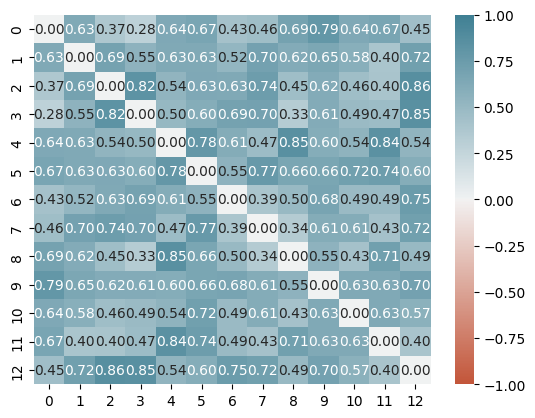

In [178]:
c = sb.diverging_palette(20, 220, as_cmap=True)
g = sb.heatmap(sim,vmin=-1,vmax=1,center=0,annot=True,fmt='.2f',cmap=c)

In [9]:
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,DBSCAN,AffinityPropagation
from sklearn.metrics import silhouette_score

In [179]:
sc = SpectralClustering(4,affinity='precomputed',assign_labels='cluster_qr')
l = sc.fit_predict(sim)
silhouette_score(dist,l,metric='precomputed')
l

array([0, 0, 3, 3, 2, 2, 3, 1, 2, 0, 1, 2, 3], dtype=int64)

In [203]:
sc = DBSCAN(min_samples = 1,metric = 'precomputed',eps=0.25)
l = sc.fit_predict(dist)
silhouette_score(dist,l,metric='precomputed')

0.1722288606251186

In [112]:
sc = AffinityPropagation(affinity='precomputed',damping=0.55)
l = sc.fit_predict(sim)
silhouette_score(dist,l,metric='precomputed')

0.16471723591623944

In [114]:
sc = AgglomerativeClustering(5,affinity='precomputed',linkage='average')
l = sc.fit_predict(sim)
silhouette_score(dist,l,metric='precomputed')

-0.26780654898722267

In [196]:
sim_thres = sim.copy()
for i in range(len(sim_thres)):
    for j in range(len(sim_thres)):
        if sim_thres[i,j] <= 0.75:
            sim_thres[i,j] = 0

In [197]:
import markov_clustering as mc
res = mc.run_mcl(sim_thres,inflation=10)
clusters = mc.get_clusters(res)

In [162]:
labels = [0 for i in range(len(sim))]
n_clus = 1
for i in clusters:
    for index in i:
        labels[index] = n_clus
    n_clus += 1

In [204]:
c = dict()
for i in range(len(l)):
    if l[i] in c:
        c[l[i]].append(i)
    else:
        c[l[i]] = [i]
c = [tuple(c[i]) for i in c]

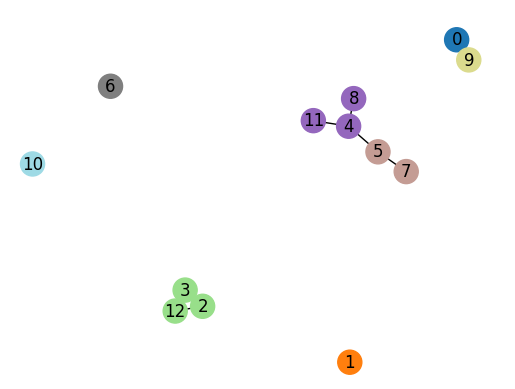

In [209]:
mc.draw_graph(sim_thres,clusters)

In [122]:
d_thres = 1-sim_thres
np.fill_diagonal(d_thres,0)

In [123]:
silhouette_score(dist,labels,metric='precomputed')

-0.022043271245715534

In [ ]:
for i in np.arange(1,10,0.1):
    res = mc.run_mcl(sim_thres,inflation=10)
    clusters = mc.get_clusters(res)
    q = mc.modularity(res,clusters)
    print(i,q)

In [200]:
mc.modularity(res,clusters)

0.30177514792899407

In [181]:
from sklearn.manifold import MDS
model = MDS(dissimilarity='precomputed')
pos = model.fit_transform(dist)

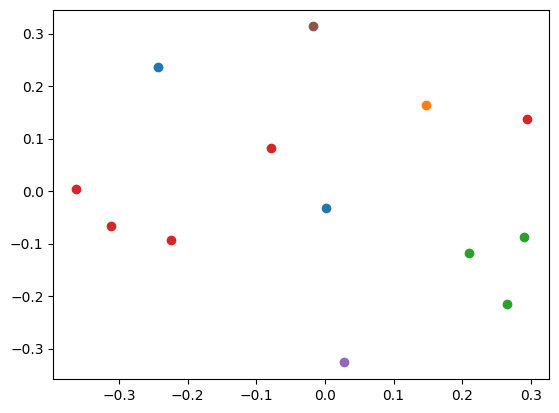

In [208]:
import matplotlib.pyplot as plt
for clu in c:
    x = []
    y = []
    for i in clu:
        x.append(pos[i, 0])
        y.append(pos[i,1])
    plt.scatter(x,y)